In [351]:
import numpy as np
def wrapAngle(angle):
    angle = angle%(2*np.pi)

    if angle>np.pi:
        angle-=2*np.pi
    elif angle<-np.pi:
        angle+=2*np.pi
    return angle

In [352]:
def unwrapAngle(angle, oldangle, residual):
    if not np.isnan(oldangle):
        if angle - oldangle < -1.5*np.pi:
            residual += 1
        elif angle - oldangle > 1.5*np.pi:
            residual -= 1
    return angle + residual * 2 * np.pi,residual

In [353]:
from numpy.random import randn

import copy
class Human(object):
    def __init__(self, pos=(0, 0, 0), vel=(0, 0, 0), noise_std=1):
        self.vel = [vel[0], vel[1], vel[2]]
        self.noise_std = noise_std
        self.pos = [pos[0], pos[1], pos[2]]
        
    def update(self,dt):
        self.vel[0] += randn() * self.noise_std
        self.vel[1] += randn() * self.noise_std
        self.vel[2] += randn() * self.noise_std
        self.pos[0] += dt*self.vel[0]
        self.pos[1] += dt*self.vel[1]
        self.pos[2] += dt*self.vel[2]
        
        dt=0.1*abs(randn()) * self.noise_std

        return [self.pos[0],
                self.pos[1],
                wrapAngle(self.pos[2]),self.pos[2]], dt

10000


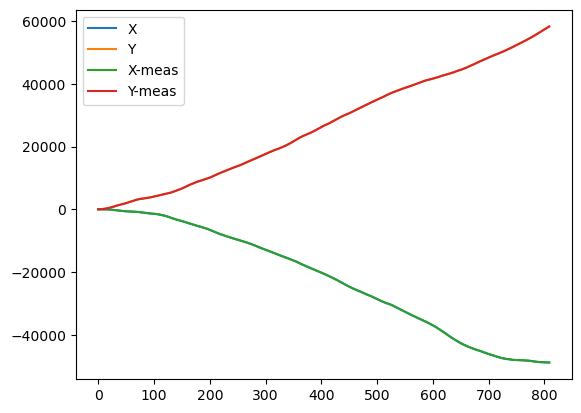

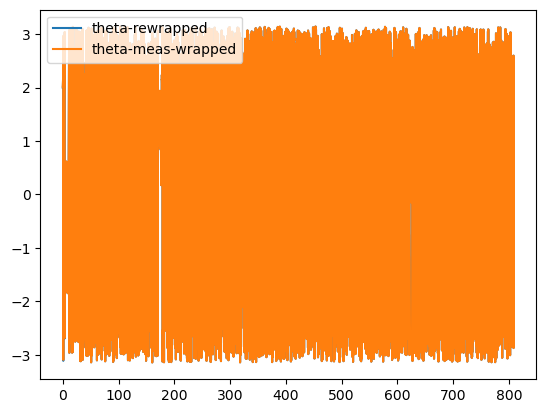

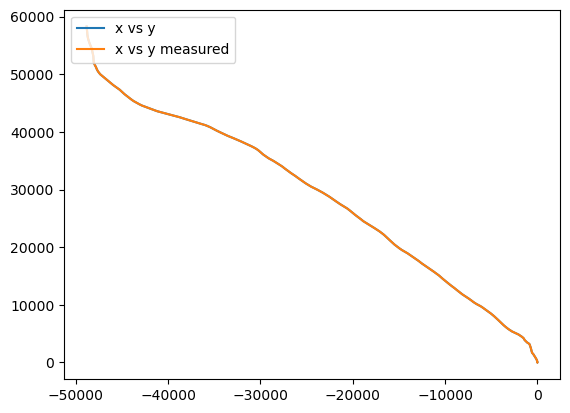

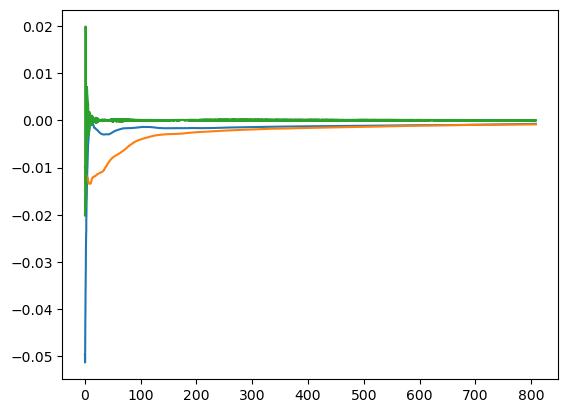

In [354]:
from filterpy.kalman import KalmanFilter
import numpy as np
from scipy.linalg import block_diag
from filterpy.common import Q_discrete_white_noise
import matplotlib.pyplot as plt
import numpy as np

class personTracker(KalmanFilter):
    def __init__(self,dt, init_pos,dim_x=6, dim_z=3):
        
        # state= x y theta dotx doty dottheta
        # measurements = x,y,theta
        super().__init__(dim_x=6,dim_z=3)
        self.generateMatricies(dt)
        self.u = 0. #no control inputs
        self.H = np.array([[1, 0, 0, 0, 0, 0],
                            [0, 1, 0, 0, 0, 0],
                            [0, 0, 1, 0, 0, 0]])
        self.R = np.eye(self.dim_z) * 5
        self.x = np.array([[init_pos[0],init_pos[1],init_pos[2], 0, 0, 0]]).T
        self.P = np.eye(self.dim_x) * 500.

    def generateMatricies(self, dt):
        #so the kalman filter can adjust to the rate
        self.F = np.array([ [1,  0, 0,  dt,   0,  0],
                            [0,  1, 0,   0,  dt,  0],
                            [0,  0, 1,   0,   0, dt],
                            [0,  0, 0,   1,   0,  0],
                            [0,  0, 0,   0,   1,  0],
                            [0,  0, 0,   0,   0,  1]])
        q = Q_discrete_white_noise(dim=self.dim_z, dt=dt, var=1.)
        self.Q = block_diag(q, q)



# def sense(x, noise_scale=1.):
#     return x[0] + randn()*noise_scale


# simulate robot movement
dt = 0.01   # time step 0.1 second
N = 10
initialMeasurement=[5,1,2]
human = Human (initialMeasurement, (0,0,0), 1.)

# run filter
person_tracker = personTracker(dt,[0,0,0])
xs,zs, time= [],[],[]
r=0
oldangle=np.nan

for i in range(N):
    person_tracker.predict()
    measurement,dt=human.update(dt)

    angleUnwrapped,r=unwrapAngle(measurement[2],oldangle,r)
    oldangle = measurement[2]
    person_tracker.generateMatricies(dt)
    (x,P)=person_tracker.get_update([measurement[:2]+[angleUnwrapped]])
    state=x
    state=np.append(state,wrapAngle(state[2]))
    xs.append(state)
    

    if i == 0:
        time.append(0)
    else:
        time.append(time[-1]+dt)

    zs.append(measurement)

print(len(xs))
resx=np.array(xs)
resz=np.array(zs)
# plot results

plt.plot(time, resx[:, 0],label="X")
plt.plot(time, resx[:, 1],label="Y")

plt.plot(time, resz[:, 0],label="X-meas")
plt.plot(time, resz[:, 1],label="Y-meas")
plt.legend(loc="upper left")
plt.show()
# plt.plot(time, resx[:, 2],label="Theta")
plt.plot(time, resx[:, 6],label="theta-rewrapped")
plt.plot(time, resz[:, 2],label="theta-meas-wrapped")
# plt.plot(time, resz[:, 3],label="theta-meas-raw")
plt.legend(loc="upper left")
plt.show()
plt.plot(resx[:, 0],resx[:, 1],label="x vs y")
plt.plot(resz[:, 0],resz[:, 1],label="x vs y measured")
plt.legend(loc="upper left")
plt.show()

plt.plot(time,abs(resx[:, 0])-abs(resz[:, 0]),label="xerror")
plt.plot(time,abs(resx[:, 1])-abs(resz[:, 1]),label="yerror")
plt.plot(time,abs(resx[:, 6])-abs(resz[:, 2]),label="thetaerror")
